# 🗳️ Elecciones EEUU

🧑‍💻 Lucía Cordero | Jorge Garcelán

![Election Results](https://www.porunmundomasjusto.es/wp-content/uploads/2020/11/mundomasjusto.png)


<div class="warning" style='padding:0.1em; border-left: 4px solid #17a2b8; background-color:#e8f8ff;'>
<span>
<p style='margin-top:1em; margin-left:1em; text-align:left'>
<b>🎯Motivación y Objetivos</b></p>
<p style='margin-left:1em;'>
Este proyecto de análisis de datos está basado en los resultados de las <strong>elecciones presidenciales de Estados Unidos de 2020</strong>. Inspirados por nuestro interés en la política y teniendo en cuenta que las elecciones presidenciales de EE.UU. de 2024 son el 5 de noviembre, se nos ocurrió abordar este tema.
<br><br>
    El objetivo es aplicar técnicas de <strong>aprendizaje supervisado</strong> y <strong>no supervisado</strong> para explorar patrones y tendencias, así como predecir los resultados electorales en función de las características socioeconómicas y demográficas de cada condado. Este enfoque nos permite estudiar cómo estos factores influyen en los comportamientos de los votantes y cómo podrían anticiparse los resultados de futuras elecciones.
</p>
</span>
</div>

<div style="border-left: 4px solid #ffa500; background-color: #fff4e5; padding: 10px;">
    <strong>⚠️Warning:</strong> Es importante mencionar que no hemos podido utilizar los datos de 2024 como test pues no se encuentran disponibles todavía.
</div>


## Librerías

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression


## Datasets

### Seleccionar año

In [9]:
CENSUS_YEAR = 2015 # 2015, 2019, 2023
ELECTORAL_YEAR = CENSUS_YEAR + 1

### Cargar datos

In [10]:
data = pd.read_csv(f'data/final_data_{ELECTORAL_YEAR}.csv')

## Aprendizaje No Supervisado

En esta sección, utilizaremos métodos de aprendizaje no supervisado, específicamente **Análisis de Componentes Principales (PCA)**, para explorar y reducir la dimensionalidad de nuestro conjunto de datos, permitiendo identificar patrones y relaciones entre las características socioeconómicas y demográficas de los condados de Estados Unidos sin la necesidad de una variable objetivo.

Además, hemos utilizado el PCA para evaluar cuántos componentes principales son necesarios para explicar un porcentaje significativo de la variabilidad en los datos, enfocándonos en lograr al menos un 90% de la varianza explicada. Este análisis nos permite identificar las características más relevantes de los condados y reducir el conjunto de datos sin perder información crítica.

### Dataset

In [65]:
columns_to_drop = [f'winner_{ELECTORAL_YEAR}', f'votes_dem_{ELECTORAL_YEAR}', f'total_votes_{ELECTORAL_YEAR}', f'votes_others_{ELECTORAL_YEAR}', f'per_dem_{ELECTORAL_YEAR}', f'per_votes_others_{ELECTORAL_YEAR}']  # Nombres de las columnas a eliminar
data_unsupervised = data.drop(columns=columns_to_drop)

### PCA

In [66]:
# Normalizamos los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_unsupervised)

# Aplicamos PCA para tres componentes
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_data)

# Creamos un dataframe para almacenar los resultados
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

print("Resultados de la matriz de PCA:")
print(pca_df)

# Return the variance explained by each principal component
print("Varianza explicada por los primeros tres componentes:")
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

Resultados de la matriz de PCA:
           PC1       PC2       PC3
0    -0.119065 -0.217482 -0.378834
1     0.388855 -2.069612 -0.595007
2    -0.830353  4.214988 -1.091920
3     0.978707  2.217467  1.455736
4     1.150449  0.191450  0.744899
...        ...       ...       ...
3107 -1.434277 -0.088007  2.768813
3108 -3.729342 -2.853847  3.154062
3109 -0.289482  0.100970  1.865868
3110  1.582311 -0.663727  1.166699
3111  2.234303 -0.953341  1.746440

[3112 rows x 3 columns]
Varianza explicada por los primeros tres componentes:
[0.24557585 0.13926465 0.09123115]


El DataFrame que tenemos representa los valores de las tres primeras componentes principales (PCA1, PCA2 y PCA3) para cada una de las 3111 observaciones del dataset, y cada fila en la matriz corresponde a una observación en los datos. Los valores en las columnas PCA1, PCA2 y PCA3 indican cómo se proyecta cada observación en estas nuevas dimensiones.

* **PCA1** explica el **27.56% de la varianza total** de los datos. Esto significa que alrededor del 27% de la información original de los datos se puede representar utilizando solo esta primera componente. **PCA2** aporta un **16.17% adicional de la varianza total**, y **PC3**, **alrededor de un 1%** sobre el total.


* En total, **las tres primeras componentes explican aproximadamente un 54.08% de la varianza de los datos originales**. Esto significa que, si solo usamos estas tres componentes, podemos capturar poco más de la mitad de la información original del conjunto de datos.

Por otro lado, sería interesante estudiar qué mínimo de componentes es necesario para explicar una cantidad significativa de la varianza (alrededor de un 90%). Vamos a verlo:

In [67]:
# Aplicamos PCA sin limitar el número de componentes para ver cuántos hacen faltapara explicar un 90% de la variabilidad
pca = PCA()  # Calcula tantos componentes como variables tenga el dataset original
pca.fit(scaled_data)

# Obtener la varianza explicada por cada componente
explained_variance_ratio = pca.explained_variance_ratio_

# Acumulamos la varianza explicada para encontrar cuántos componentes se necesitan para explicar el 90%
cumulative_variance = np.cumsum(explained_variance_ratio)

# Encontramos el número mínimo de componentes que explican al menos el 90% de la varianza
num_components_90_variance = np.argmax(cumulative_variance >= 0.90) + 1

# Imprimimos los resultados
print(f"Se necesitan {num_components_90_variance} componentes principales para explicar el 90% de la varianza.")

# Opcional: Mostrar la varianza acumulada
for i, var in enumerate(cumulative_variance, 1):
    print(f"Componentes: {i}, Varianza Acumulada: {var:.4f}")

Se necesitan 15 componentes principales para explicar el 90% de la varianza.
Componentes: 1, Varianza Acumulada: 0.2456
Componentes: 2, Varianza Acumulada: 0.3848
Componentes: 3, Varianza Acumulada: 0.4761
Componentes: 4, Varianza Acumulada: 0.5499
Componentes: 5, Varianza Acumulada: 0.6101
Componentes: 6, Varianza Acumulada: 0.6591
Componentes: 7, Varianza Acumulada: 0.7004
Componentes: 8, Varianza Acumulada: 0.7406
Componentes: 9, Varianza Acumulada: 0.7790
Componentes: 10, Varianza Acumulada: 0.8098
Componentes: 11, Varianza Acumulada: 0.8345
Componentes: 12, Varianza Acumulada: 0.8544
Componentes: 13, Varianza Acumulada: 0.8716
Componentes: 14, Varianza Acumulada: 0.8879
Componentes: 15, Varianza Acumulada: 0.9035
Componentes: 16, Varianza Acumulada: 0.9164
Componentes: 17, Varianza Acumulada: 0.9280
Componentes: 18, Varianza Acumulada: 0.9388
Componentes: 19, Varianza Acumulada: 0.9476
Componentes: 20, Varianza Acumulada: 0.9557
Componentes: 21, Varianza Acumulada: 0.9623
Componen

In [68]:
# Calculamos explained variance ratio y varianza cumulativa
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Lista de variables de los datos
feature_names = ['age_over_18_2019', 'age_over_65_2019', 'asian_2019',
       'avg_family_size_2019', 'bachelors_2019', 'black_2019', 'hispanic_2019',
       'households_speak_limited_english_2019', 'hs_grad_2019',
       'median_age_2019', 'native_2019', 'other_single_race_2019',
       'pac_isl_2019', 'per_capita_income_2019', 'pop_2019',
       'two_plus_races_2019', 'unemployment_rate_2019', 'uninsured_2019',
       'veterans_2019', 'white_2019', 'white_not_hispanic_2019']


hover_text = []
for i, component in enumerate(pca.components_):
    # Obtener top 5 variables que más contribuyen
    top_features_idx = np.argsort(np.abs(component))[-5:]
    
    # Verificar que no excedemos límites de la lista de variables
    if max(top_features_idx) < len(feature_names):
        top_features = [feature_names[idx] for idx in top_features_idx]
    else:
        top_features = [feature_names[idx] for idx in top_features_idx if idx < len(feature_names)]
    
    hover_text.append(f'Componente {i+1}: Top Variables:<br>' + '<br>'.join(top_features))

# Gráfico para la varianza explicada
trace1 = go.Bar(
    x=[f'PC {i+1}' for i in range(len(explained_variance_ratio))],
    y=explained_variance_ratio * 100,
    name='Varianza Explicada',
    hovertext=hover_text,
    hoverinfo='text',
    marker=dict(color='#377eb8'),
    opacity=0.7
)

# Line plot para varianza cumulativa
trace2 = go.Scatter(
    x=[f'PC {i+1}' for i in range(len(cumulative_variance))],
    y=cumulative_variance * 100,
    mode='lines+markers',
    name='Varianza Cumulativa',
    line=dict(color='black'),
    hoverinfo='y'
)

# Índice donde la varianza cumulativa está más cerca a 90%
threshold_idx = np.argmax(cumulative_variance >= 0.90)

# Aañdir cruz en el punto donde la varianza cumulativa es 90%
red_cross = go.Scatter(
    x=[f'PC {threshold_idx+1}'],
    y=[cumulative_variance[threshold_idx] * 100],
    mode='markers',
    marker=dict(color='#e41a1c', size=10, symbol='x'),
    name='90% Varianza Cumulativa'
)

# Layout
layout = go.Layout(
    title='Distribución de la varianza explicada por cada componente principal',
    xaxis=dict(title='Principal Components'),
    yaxis=dict(title='Porcentaje de Varianza Explicada'),
    showlegend=True
)

# Crear gráfico
fig = go.Figure(data=[trace1, trace2, red_cross], layout=layout)

# Mostrar
fig.show()

FileNotFoundError: [Errno 2] No such file or directory: '../IMAGES/pca_cumulative.png'

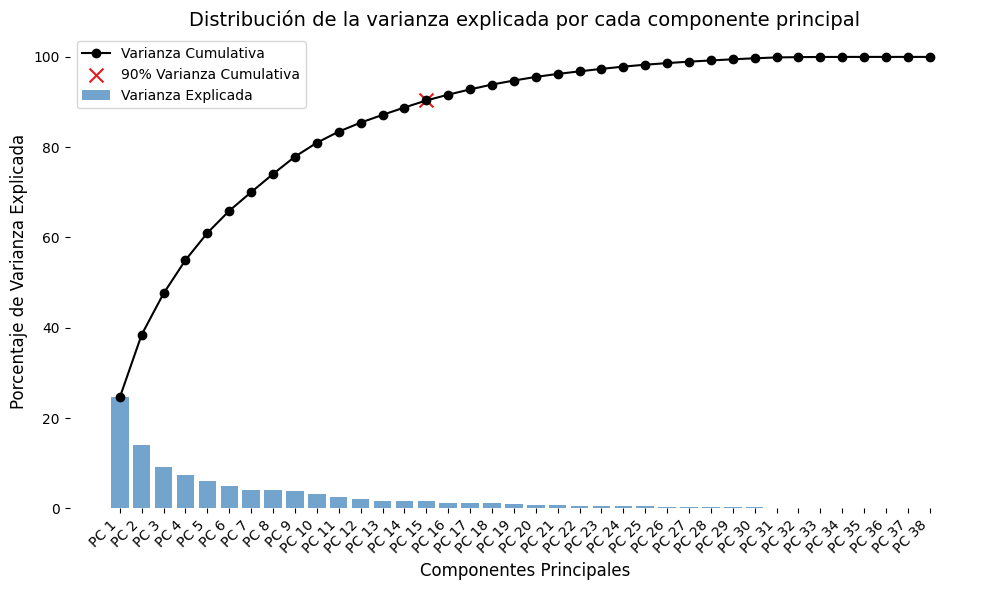

In [69]:
# Calculamos explained variance ratio y varianza cumulativa
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Crear gráfico de barras para la varianza explicada
plt.figure(figsize=(10, 6))

# Gráfico de barras para varianza explicada
plt.bar(x=[f'PC {i+1}' for i in range(len(explained_variance_ratio))],
        height=explained_variance_ratio * 100, color='#377eb8', alpha=0.7, label='Varianza Explicada')

# Gráfico de líneas para la varianza cumulativa
plt.plot([f'PC {i+1}' for i in range(len(cumulative_variance))],
         cumulative_variance * 100, color='black', marker='o', label='Varianza Cumulativa')

# Índice donde la varianza cumulativa está más cerca al 90%
threshold_idx = np.argmax(cumulative_variance >= 0.90)

# Añadir una cruz roja en el punto donde la varianza cumulativa es 90%
plt.scatter([f'PC {threshold_idx+1}'], [cumulative_variance[threshold_idx] * 100],
            color='#e41a1c', label='90% Varianza Cumulativa', marker='x', s=100)

# Añadir títulos y etiquetas
plt.title('Distribución de la varianza explicada por cada componente principal', fontsize=14)
plt.xlabel('Componentes Principales', fontsize=12)
plt.ylabel('Porcentaje de Varianza Explicada', fontsize=12)

# Rotar las etiquetas del eje X
plt.xticks(rotation=45, ha='right')

# Añadir leyenda
plt.legend()

# Ajustar layout
plt.tight_layout()

# Eliminar los bordes y la línea negra alrededor del gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Guardar el gráfico como PNG con fondo transparente
plt.savefig("../IMAGES/pca_cumulative.png", format="png", transparent=True)

# Mostrar el gráfico
plt.show()

Reducir las dimensiones de los datos permite construir modelos más simples, con menos riesgo de sobreajuste, ya que se eliminan las variables que contribuyen poco a la variación total, manteniendo solo las más relevantes.

En términos prácticos, podemos **reducir nuestros datos de 25 dimensiones** (ya que originalmente teníamos 25 variables) **a 11 componentes**, preservando el 90% de la variabilidad original.

Por otro lado, vemos colocando el ratón sobre el bar plot que los cinco atributos que más variabilidad explican sobre el dataset (los cinco que más contribuyen al PC1) son:
- white_not_hispanic_2019
- avg_family_size_2019
- median_age_2019
- white_2019
- households_speak_limited_english

Estas parecen ser variables que tienen mucha fluctuación dependiendo del condado, afectando también los resultados electorales. El siguiente gráfico muestra todas las variables que contribuyen al primer componente principal, y en qué medida.


In [ ]:
# Explained variance ratio for PCA
explained_variance_ratio = pca.explained_variance_ratio_

# Loadings (how much each variable contributes to each component)
loadings = pca.components_.T * np.sqrt(explained_variance_ratio)

# Create a DataFrame for better handling of the loadings
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=data_unsupervised.columns)

# Calculate mean contribution for PC1
mean_contribution = loadings_df['PC1'].abs().mean()

# Create an interactive bar plot using Plotly
fig = go.Figure()

# Add bars for PC1 contributions
fig.add_trace(go.Bar(
    x=loadings_df['PC1'].abs().sort_values(ascending=False).index,  # Variables
    y=loadings_df['PC1'].abs().sort_values(ascending=False),         # Loadings (absolute)
    name='PC1 Contribución',
    marker_color='#377eb8',
    opacity=0.7
))

# Add a horizontal dashed line for mean contribution
fig.add_hline(y=mean_contribution, line_dash="dash", line_color="#e41a1c",
              annotation_text="Contribución Media", annotation_position="top right")

# Customize layout
fig.update_layout(
    title='Contribución de Variables a PC1',
    xaxis_title='Variables',
    yaxis_title='Contribución (%)',
    xaxis_tickangle=-45,  # Rotate x labels
    showlegend=True,
    template='plotly_white'
)

# Show the interactive plot
fig.show()

In [ ]:
# Explained variance ratio for PCA
explained_variance_ratio = pca.explained_variance_ratio_

# Loadings (how much each variable contributes to each component)
loadings = pca.components_.T * np.sqrt(explained_variance_ratio)

# Crear un DataFrame para manejar mejor los "loadings"
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=data_unsupervised.columns)

# Calcular la contribución media para PC1
mean_contribution = loadings_df['PC1'].abs().mean()

# Ordenar las contribuciones de PC1 de mayor a menor
pc1_contributions = loadings_df['PC1'].abs().sort_values(ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(pc1_contributions.index, pc1_contributions.values, color='#377eb8', alpha=0.7)

# Añadir una línea horizontal para la contribución media
plt.axhline(y=mean_contribution, color='#e41a1c', linestyle='--', label='Contribución Media')

# Añadir etiquetas y título
plt.title('Contribución de Variables a PC1', fontsize=14)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Contribución (%)', fontsize=12)

# Rotar las etiquetas del eje X
plt.xticks(rotation=45, ha='right')

# Añadir la leyenda
plt.legend()

# Ajustar el layout para que las etiquetas no se solapen
plt.tight_layout()

# Eliminar los bordes y la línea negra alrededor del gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Guardar el gráfico como PNG con fondo transparente
plt.savefig("../IMAGES/pca_variables_pc1.png", format="png", transparent=True)

# Mostrar el gráfico
plt.show()

El PC1, el componente que más variabilidad de los datos explica, refleja tendencias demográficas y socioeconómicas en los condados. Aunque las que mencionábamos antes son las variables que cuyos cambios generan más fluctuaciones sobre el componente PCA1, habría que plantearse también si generan un cambio positivo o negativo sobre el mismo, vamos a verlo:

In [ ]:
plt.figure(figsize=(10, 6))
loadings_df['PC1'].plot(kind='bar', color='#377eb8',  width=0.8, alpha=0.7)
plt.title('Loadings de las Variables en PC1')
plt.ylabel('Loading')
plt.xlabel('Variables')
plt.axhline(0, color='black', linewidth=1)  # Line at 0 to separate positive and negative loadings
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Eliminar los bordes y la línea negra alrededor del gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Guardar el gráfico como PNG con fondo transparente
plt.savefig("../IMAGES/pca_loadings_pc1.png", format="png", transparent=True)

plt.show()

Basado en las cargas observadas en este gráfico:

* PC1 está positivamente correlacionado con mayor porcentaje de población blanca no hispana (*white_not_hispanic_2019*), edad mayor (*age_over_65_2019*), y familias más grandes (*avg_family_size_2019*).

* Está negativamente correlacionado con el porcentaje de población hispana (*hispanic_2019*), personas que hablan inglés limitado (*households_speak_limited_english_2019*), y tasa de desempleo (*unemployment_rate_2019*).

En resumen, PC1 parece estar diferenciando condados en función de sus características demográficas y económicas, como la composición racial, el nivel de inglés, y la tasa de desempleo.

In [ ]:
# Scale factor for the arrows
arrow_scale = 18
font_size = 10

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c='#377eb8', alpha=0.5, label="Condados")

# Add title and labels
plt.title('PCA: Dos primeros componentes principales')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# Plot the arrows without text
for component_1, component_2 in zip(pca.components_[0], pca.components_[1]):
    plt.arrow(0, 0, component_1 * arrow_scale, component_2 * arrow_scale,
              color='#e41a1c', head_width=0.3, head_length=0.5)
    
# Plot the arrows with text
for i, (component_1, component_2) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, component_1 * arrow_scale, component_2 * arrow_scale,
              color='#e41a1c', head_width=0.3, head_length=0.5)
    plt.text(component_1 * arrow_scale * 1.3, component_2 * arrow_scale * 1.3,
             feature_names[i], color='black', ha='center', va='center', fontsize=font_size)

# Eliminar los bordes y la línea negra alrededor del gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Guardar el gráfico como PNG con fondo transparente
plt.savefig("../IMAGES/pca_pc1_pc2.png", format="png", transparent=True)

# Add grid for better readability
plt.grid(True)

# Display the improved plot
plt.legend()
plt.show()

Si lo vemos en el anterior diagrama de dispersión, podríamos asumir que los condados caracterizados por un mayor porcentaje de población blanca, familias más grandes, mayor porcentaje de militares y población más envejecida se encuentran en el cuadrante positivo del mapa (ya que tienen valores altos de variables que tienen carga positiva).

Por otro lado, en el cuadrante izquierdo se encuentran condados con mayores tasas de paro, familias más pequeñas, más población hispana y con más población que tiene un nivel de inglés limitado.